# API TDD (Test-Driven Development)

The purpose of this notebook is to work out how a user may want to use the library. Code will be written using the desired API/syntax, and then the library will be adjusted. Functions that are not of interest to a typical user will be rendered private (\_privatename single underscore convention).

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'svg'  # makes inline plot look less blurry

In [3]:
home_path = os.path.abspath(os.path.join('..'))
if home_path not in sys.path:
    sys.path.append(home_path)

In [4]:
tests_path = os.path.abspath(os.path.join('..', 'tests'))
if tests_path not in sys.path:
    sys.path.append(tests_path)

## Definitions

* multiplet
* spin system
* spectrum
* peak
* peaklist
* lineshape



## Scenario: user wants to plot a spectrum for an ABX 3-spin system.


Setup: user has v (frequency) and J (coupling constant) data as python lists (or numpy arrays). For this example, a function from nmrtool's test suite will provide some example data:

In [5]:
# load the parameters used by Rioux for his example at:
# http://www.users.csbsju.edu/~frioux/nmr/ABC-NMR-Tensor.pdf
from simulation_data import rioux

In [6]:
v, J = rioux()
print(v)  # frequencies in Hz
print(J)  # matrix of coupling constants

[430. 265. 300.]
[[ 0.   7.  15. ]
 [ 7.   0.   1.5]
 [15.   1.5  0. ]]


The J matrix is constructed so that J[a, b] is the coupling constant between v[a] and v[b]. The diagonal elements should be 0.

### Method A: using the SpinSystem class

In [7]:
from nmrtools import SpinSystem

In [8]:
abx_system = SpinSystem(v, J)

[430. 265. 300.] [[ 0.   7.  15. ]
 [ 7.   0.   1.5]
 [15.   1.5  0. ]] True <bound method SpinSystem.peaklist of <nmrtools._classes.SpinSystem object at 0x0000019C3C847710>>


The nmrtools.plt library has functions for convenient plotting of common nmrtools data types (peaklist; lineshape).

In [9]:
from nmrtools.plt import mplplot

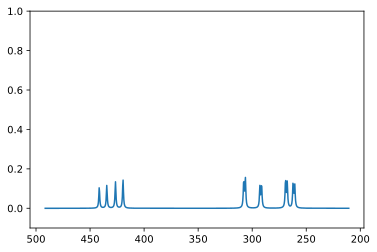

In [10]:
mplplot(abx_system.peaklist());

To plot the spectra as a "stick" style plot (single lines for each peak, rather than a simulated lineshape), you can use the mplplot_stick function instead of mplplot:

In [11]:
from nmrtools.plt import mplplot_stick

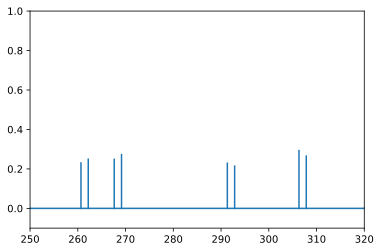

(array([260.66152857, 291.31911367, 419.51935776, 292.84688854,
        426.48774469, 262.18930345, 434.52319595, 267.62991551,
        306.32295186, 441.49158288, 307.85072673, 269.15769038,
        250.        , 320.        ]),
 array([0.23011249, 0.22882003, 0.29107245, 0.21381231, 0.26629868,
        0.24876062, 0.23004586, 0.24855579, 0.2925168 , 0.21257278,
        0.26486802, 0.27256417, 0.001     , 0.001     ]))

In [12]:
mplplot_stick(abx_system.peaklist(), limits=(250, 320))

SpinSystem defaults to second-order simulation of a spin system. If the SpinSystem object is instantiated with the `second_order=False` keyword argument, or if the SpinSystem.second_order attribute is set to `False`, first-order simulation will be performed instead.

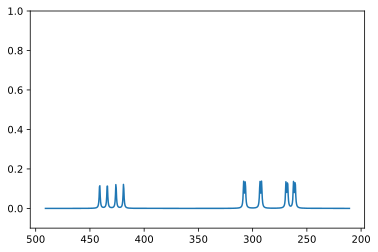

In [13]:
abx_system.second_order = False
mplplot(abx_system.peaklist());

### Method B: using lower-level API

The `nmrtools.qm` module provides functions for the quantum-mechanical calculation of NMR spectra.

In [14]:
from nmrtools import qm

In [15]:
spectrum = qm.spectrum(v, J, normalize=True)
spectrum
# TODO: refactor "spectrum" to "peaklist"

[(260.66152857482973, 0.2301124913178783),
 (291.3191136690316, 0.22882003310401844),
 (419.5193577561387, 0.29107244545559474),
 (292.84688854093866, 0.21381231157251776),
 (426.4877446901903, 0.26629867696733883),
 (262.18930344673686, 0.2487606172641341),
 (434.52319595017997, 0.2300458619680737),
 (267.62991550888137, 0.24855578963215696),
 (306.32295186307283, 0.29251680284079623),
 (441.4915828842316, 0.21257278181929298),
 (307.85072673497996, 0.26486802047130636),
 (269.1576903807885, 0.2725641675868917)]

When normalize=True, the total intensities should add up to the total number of nuclei in the spin system.

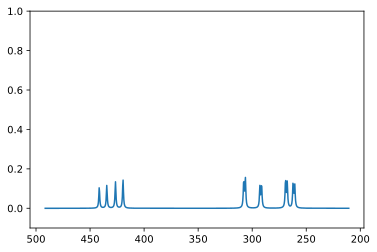

In [16]:
mplplot(spectrum);

The `nmrtools.firstorder` module provides functions for calculating first-order NMR spectra. The `first_order_spin_system` functon accepts the same v, J inputs as for a second-order computation.

In [17]:
from nmrtools.firstorder import first_order_spin_system

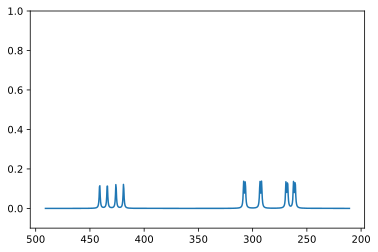

In [18]:
peaklist = first_order_spin_system(v, J)
mplplot(peaklist);

__How does a user want their spectrum?__ Currently a list of tuples is provided. Some routines may be better implemented if the spectrum remained a numpy array. e.g. compile_spectrum provides a 2D array of `[[frequency, intensity]...]`. normalize_spectrum then separates into frequency and intensity arrays, processes the latter, then puts them back together.

Need to survey how the most common plotting libraries handle x, y data. Two scenarios: lineshape, and stick.

Note that a spectrum with [(v, I)...] format can be easily converted to [v...], [I...]:
`v, I = zip(*spectrum)`


__What is a multiplet, and what can you do with it?__ It has v, I, and J information. If multiplied, the intensity increases. If added, you get a spectrum. < and > may not make sense (but could be v order; probably not I order). Challenge: representation? Can you get it to determine dt, td etc?

## Scenario: User wants to simulate individual first-order multiplets

The Multiplet class can be used to represent an individual first-order multiplet.

In [19]:
from nmrtools import Multiplet

Required arguments for Multiplet are the central frequency `v`, the intensity ("integration") in the absence of coupling, and a list of coupling data. Each list entry is a tuple of (J value in Hz, number of nuclei causing the coupling). For example, the following Multiplet represents: 1200 Hz, 2H, td, J = 7.1, 1.1 Hz.

In [20]:
# 1200 Hz, 2H, td, J= 7.1, 1.1 Hz
td = Multiplet(1200.0, 2, [(7.1, 2), (1.1, 1)])
print(td.v)
print(td.J)

1200.0
[(7.1, 2), (1.1, 1)]


In [21]:
# from nmrtools.plt import mplplot_stick

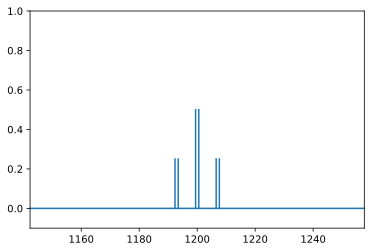

In [22]:
mplplot_stick(td.peaklist());

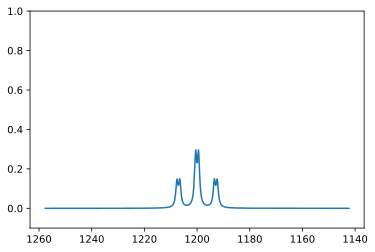

In [23]:
mplplot(td.peaklist());

Multiplet attributes can be modified. 

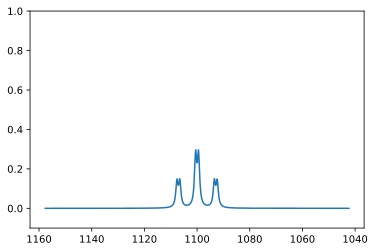

In [24]:
td2 = Multiplet(1200.0, 2, [(7.1, 2), (1.1, 1)])
td2.v = 1100
mplplot(td2.peaklist());

If a Multiplet is multiplied by a scalar, a new Multiplet is returned that has all intensities multiplied by the scalar. In-place multiplication (\*=) modifies the original Multiplet object.

In [25]:
td3 = td2 * 2
td2 *= 2
assert td2 is not td3

Multiplets are equal to each other if their peaklists are equal.

In [25]:
assert td2 == td3

Division and division in place is also possible:

In [25]:
td4 = td2 / 2
td2 /= 2
assert td4 == td2

In [42]:
td3 /= 0

ZeroDivisionError: division by zero

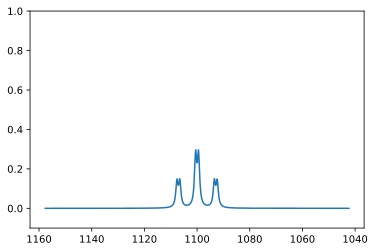

In [27]:
mplplot(td2.peaklist());

In [28]:
Multiplet.v.storage_name

'_Number#0'

In [29]:
help(Multiplet.v)

Help on Number in module nmrtools._descriptors object:

class Number(Validated)
 |  test that a value is a real number
 |  
 |  Method resolution order:
 |      Number
 |      Validated
 |      abc.ABC
 |      AutoStorage
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  validate(self, instance, value)
 |      return validated value or raise ValueError
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __abstractmethods__ = frozenset()
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Validated:
 |  
 |  __set__(self, instance, value)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from Validated:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  -----------------

In [30]:
hasattr(Multiplet, 'x') and callable(Multiplet.x)

False

## Scenario: User wants to add two multiplets together to get a spectrum

In [31]:
from nmrtools import Spectrum

In [32]:
import itertools

In [33]:
spectrum = td + td2

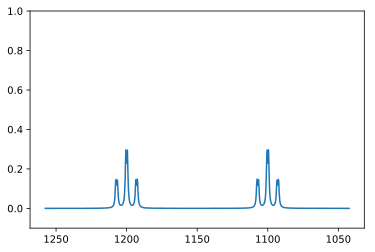

In [34]:
mplplot(spectrum.peaklist());

In [35]:
a = spectrum.peaklist()

In [36]:
p = [[(1, 2), (3, 4)], [(5, 6), (7, 8)]]
combo = itertools.chain.from_iterable(p)
list(combo)

[(1, 2), (3, 4), (5, 6), (7, 8)]

## Scenario: User wants to model a specific spin system using an explicit (non-qm) solution

--> nmrtools.partial

In [37]:
import timeit

## Scenario: User wants to model DNMR two-spin exchange, without and with coupling

The nmrtools.dnmr library provides functions for calculating DNMR lineshapes, and classes to describe these systems. Currently models for two uncoupled nuclei and two coupled nuclei are provided.

In [38]:
from nmrtools.dnmr import DnmrTwoSinglets, DnmrAB

For: v<sub>a</sub> = 165 Hz, v<sub>b</sub> = 135 Hz, k = 65.9 {todo: units}, line widths (at the slow exchange limit) w<sub>a</sub> and w<sub>b</sub> = 0.5 Hz, and population of state a = 0.5 (i.e. 50%):

In [39]:
two_singlet_system = DnmrTwoSinglets(165.00, 135.00, 65.9, 0.50, 0.50, 0.50)

In [40]:
mpl_lineshape(*two_singlet_system.spectrum());  # TODO: rename to lineshape?

NameError: name 'mpl_lineshape' is not defined

When using the provided classes, individual parameters can be changed. In the previous case, k = 65.9 corresponds to the point of coalescence. When the rate of exchange is lower, two separate peaks are observed.

In [ ]:
two_singlet_system.k = 5

In [ ]:
mpl_lineshape(*two_singlet_system.spectrum());

What if the relative populations of states a and b are 75% and 25%, respectively?

In [ ]:
two_singlet_system.pa = 0.75
mpl_lineshape(*two_singlet_system.spectrum());

Now, model an AB-like system of two coupled nuclei undergoing exchange. Here, the frequencies are the same as for the previous system. J = 5 Hz, k = 12 {units}, and the line width (at the slow exchange limit) is 0.5 Hz.

In [ ]:
from nmrtools.dnmr import DnmrAB

In [ ]:
AB = DnmrAB(165, 135, 5, 10, 0.5)

In [ ]:
mpl_lineshape(*AB.spectrum());